In [1]:
#import libraries
import pandas as pd
import math
import re
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
import lda
from dateutil import parser
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pyelasticsearch import ElasticSearch
from time import time
import fasttext
import json
import seaborn as sns
pd.options.display.max_colwidth = 140
%matplotlib inline

#path to data
DATA_DIR = 'data/'

# Trump data acquisition and description

We have acquired the dataset containing tweets by Donald Trump via the link provided in the projects datasets. We have accessed the following link : http://www.trumptwitterarchive.com/archive and downloaded all of Trump's tweets in csv format.<br/>
The data has the following fields :<br/>
1. source : contains the platform used to create the tweet
2. text : the content of the tweet
3. created_at : the date of the tweet
4. retweet_count : the number of times this tweet has been retweeted
5. favorite_count : the number of times this tweet was favorited
6. is_retweet : boolean value indicating whether or not this tweet was a retweet
7. id_str : the unique identifier of a tweet

From the previous fields, we will need : the text field in order to do the topic extraction, the created_at field to see the evolution of topics over the years, favorite_count and retweet_count as basic indicators of a tweet's popularity.<br/>

In [2]:
# load the Trump tweets data set
trump_df = pd.read_csv(DATA_DIR + 'trump_tweets.csv',encoding = "ISO-8859-1")
trump_df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Leaving South Korea now heading to China. Looking very much forward to meeting and being with President Xi!,11.08.17 4:57,4901.0,23854,FALSE,9.281240e+17
1,Twitter Web Client,Together we dream of a Korea that is free a peninsula that is safe and families that are reunited once again! https://t.co/9tsZRCC83j,11.08.17 3:43,6232.0,22850,FALSE,9.281060e+17
2,Twitter Web Client,Anyone who doubts the strength or determination of the U.S. should look to our past....and you will doubt it no longer. https://t.co/zyu...,11.08.17 3:14,6648.0,24794,FALSE,9.280980e+17
3,Twitter Web Client,The North Korean regime has pursued its nuclear &amp; ballistic missile programs in defiance of every assurance agreement &amp; commmitm...,11.08.17 3:12,5513.0,19798,FALSE,9.280980e+17
4,Twitter Web Client,The U.S. under my administration is completely rebuilding its military and they're spending hundreds of billions of dollars to the newes...,11.08.17 3:09,7325.0,26769,FALSE,9.280970e+17


We first look at the size of our dataset.

In [3]:
original_size = trump_df.shape[0]
print('The number of tweets by Donald Trump before pre-processing is ' + str(original_size))

The number of tweets by Donald Trump before pre-processing is 29597


We remove tweets for which any of the fields is null.

In [4]:
trump_df.dropna(inplace=True)
print('Dropped ' + str(original_size - trump_df.shape[0]) + ' rows which contained NaN values.')

Dropped 5 rows which contained NaN values.


We show some summary statistics on the numerical fields.

In [5]:
trump_df['favorite_count'] = pd.to_numeric(trump_df['favorite_count']) 
trump_df[['favorite_count', 'retweet_count']].describe()

,favorite_count,retweet_count
count,29592.000000,29592.000000
mean,8729.093167,2662.950764
std,25487.460766,7461.986856
min,0.000000,0.000000
25%,21.000000,17.000000
50%,70.000000,113.500000
75%,2017.000000,1235.250000
max,633253.000000,369530.000000


We notice inconsistencies in the 'created_at' field. Some dates are written in the following format: <b>dd.mm.yy</b>, while others are written in the following format: <b>dd-mm-yy</b>.<br>
In order to stay consistent, we split this field into Day, Month and Year fields.

In [6]:
def parse_date(date):
    #returns the day, the month, and the year from a given date string
    split_dot = date.split(' ')[0].split('.')
    if (len(split_dot) == 3):
        #if year is only 2 digits, concatenate '20' to the left
        year = split_dot[2]
        if (len(year) == 2):
            year = '20' + str(year)
        return split_dot[0], split_dot[1], year
    else:
        split_dash = date.split(' ')[0].split('-')
        #if year is only 2 digits, concatenate '20' to the left
        year = split_dash[2]
        if (len(year) == 2):
            year = '20' + str(year)
        return split_dash[0], split_dash[1], year
    
def get_day(date):
    return parse_date(date)[0]
def get_month(date):
    return parse_date(date)[1]
def get_year(date):
    return parse_date(date)[2]

trump_df['day'] = trump_df['created_at'].apply(get_day)
trump_df['month'] = trump_df['created_at'].apply(get_month)
trump_df['year'] = trump_df['created_at'].apply(get_year)
trump_df.drop('created_at', axis=1, inplace=True)
trump_df.head()

,source,text,retweet_count,favorite_count,is_retweet,id_str,day,month,year
0,Twitter for iPhone,Leaving South Korea now heading to China. Looking very much forward to meeting and being with President Xi!,4901.0,23854,FALSE,9.281240e+17,11,08,2017
1,Twitter Web Client,Together we dream of a Korea that is free a peninsula that is safe and families that are reunited once again! https://t.co/9tsZRCC83j,6232.0,22850,FALSE,9.281060e+17,11,08,2017
2,Twitter Web Client,Anyone who doubts the strength or determination of the U.S. should look to our past....and you will doubt it no longer. https://t.co/zyu...,6648.0,24794,FALSE,9.280980e+17,11,08,2017
3,Twitter Web Client,The North Korean regime has pursued its nuclear &amp; ballistic missile programs in defiance of every assurance agreement &amp; commmitm...,5513.0,19798,FALSE,9.280980e+17,11,08,2017
4,Twitter Web Client,The U.S. under my administration is completely rebuilding its military and they're spending hundreds of billions of dollars to the newes...,7325.0,26769,FALSE,9.280970e+17,11,08,2017


# Trump tweets pre-processing
We define different functions in order to clean the text to be able to perform better topic extraction.
First, we get rid of contractions in a tweet (don't, doesn't, won't etc.). We also remove any URLs from the data. We get rid of any special characters and punctuation. We also remove any words that contain numbers. The clean text function applies all the aforementioned modifications to a tweet.  It also retains only alphanumeric characters as some of the tweets contained Japanese characters for example. In addition, the clean text function also performs word lemmatization, so that words with similar meaning get represented in the same way. <br/>
Note that some of these functions will also be used when cleaning the Twitter dump data before doing the sentiment analysis and the topic extraction on them.

In [7]:
def fix_contractions(document):
    """
    Remove contractions from document
    :param document: where we want to remove the contractions
    :return: the document without contractions
    """
    match_list = re.findall(r"\w+(?=n't)|n't|\w+(?=')|'\w+|\w+",document, re.IGNORECASE | re.DOTALL)
    ans = " ".join(match_list)
    return ans.lstrip().rstrip()

def remove_link(document):
    """
    Remove links and fix U.S. shortname
    :param document: where we want to remove the link
    :return: the document without a link
    """
    result = ""
    for word in document.split():
        if(not(word[:4] == "http") and not(word[0] == '&') and not(word[len(word)-1] == ';')):
            if(word == "u.s."):
                result += " usa"
            else:
                result += " " + word

    return result.lstrip().rstrip()

def remove_special_characters(documents):
    """
    Remove special characters
    :param documents: the documents from where we remove the characters
    :return: the documents without the special characters
    """
    documents_no_specials = []
    for item in documents:
        try:
            documents_no_specials.append(
                item.replace('\r', ' ').replace('/n', ' ')\
                    .replace('.', ' ').replace(',', ' ').replace('(', ' ') \
                    .replace(')', ' ').replace('"', ' ') \
                    .replace('!', ' ').replace('?', ' ') \
                    .replace('>', ' ').replace('$', ' ') \
                    .replace('-', ' ').replace(';', ' ') \
                    .replace(':', ' ').replace('/', ' ').replace('#', ' ').replace('@',' '))
        except:
            documents_no_specials.append("")
    
    result = ""
    for ch in documents_no_specials:
            result = result + ch
    return result

def remove_numerical(documents):
    """
    remove the words containing numbers
    :param documents: 
    :return: 
    """
    result = ""
    for word in documents.split():
        new_word = ''.join([i for i in word if not i.isdigit()])
        result = result + " " + new_word
    return result

def clean_text(documents):
    """
    remove special characters, stop words and numbers, lemmatize and remove non-english words 
    :param documents: Docuements to clean
    :param tester: which element you would like to display as an example
    :return: the cleaned documents
    """
    lemmatizer = WordNetLemmatizer()

    # Remove numbers
    documents_no_link_no_numeric = remove_numerical(documents)
    
    #Everything to lower case
    documents = documents_no_link_no_numeric.lower()
    
    # Remove links
    documents_no_link = remove_link(documents)
    
    # Remove special characters
    documents_no_specials = remove_special_characters(documents_no_link)
    
    #Remove contractions
    documents_fixed_words = fix_contractions(documents_no_specials)
  
    # remove words with length equal to 1
    documents_remove_shortwords = " ".join([token for token in documents_fixed_words.split() 
                                                       if (len(token)>1)])
    
    documents_finished = re.sub('[^a-zA-Z]+', ' ',documents_remove_shortwords)
    
    documents_finished = " ".join([token for token in documents_finished.split() if (token not in STOPWORDS)])
    
    documents_finished = " ".join([lemmatizer.lemmatize(token) for token in documents_finished.split()])
    
    # remove words with length equal to 1
    documents_finished = " ".join([token for token in documents_finished.split() 
                                                       if (len(token)>1)])
    
    #remove specific words
    documents_finished = " ".join([token for token in documents_finished.split() if (not token in "realdonaldtrump")])
    
    return documents_finished


We apply the clean text function to the text column of the dataframe, and obtain a dataframe with an additional column containing the clean text, on which we can now try different topic identifiation methods.<br/>
We drop any rows for which the text field became empty after preprocessing. <br/>
We also save the clean tweets dataframe to a new csv file so that we can use it easily.

In [8]:
#Apply clean text to entire column
trump_df['text_processed'] = trump_df['text'].apply(clean_text)
num_empty_text = trump_df[trump_df['text_processed'] == ''].shape[0]

# Remove rows where processed text is empty
trump_df = trump_df[trump_df['text_processed'] != '']
print('Dropped ' + str(num_empty_text) + ' rows with empty text after preprocessing.')

#Save processed tweets
trump_df.to_csv(DATA_DIR + "trump_tweets_processed.csv",  index=False)

trump_df.head()

Dropped 11 rows with empty text after preprocessing.


,source,text,retweet_count,favorite_count,is_retweet,id_str,day,month,year,text_processed
0,Twitter for iPhone,Leaving South Korea now heading to China. Looking very much forward to meeting and being with President Xi!,4901.0,23854,FALSE,9.281240e+17,11,08,2017,leaving south korea heading china looking forward meeting president xi
1,Twitter Web Client,Together we dream of a Korea that is free a peninsula that is safe and families that are reunited once again! https://t.co/9tsZRCC83j,6232.0,22850,FALSE,9.281060e+17,11,08,2017,dream korea free peninsula safe family reunited
2,Twitter Web Client,Anyone who doubts the strength or determination of the U.S. should look to our past....and you will doubt it no longer. https://t.co/zyu...,6648.0,24794,FALSE,9.280980e+17,11,08,2017,doubt strength determination usa look past doubt longer
3,Twitter Web Client,The North Korean regime has pursued its nuclear &amp; ballistic missile programs in defiance of every assurance agreement &amp; commmitm...,5513.0,19798,FALSE,9.280980e+17,11,08,2017,north korean regime pursued nuclear ballistic missile program defiance assurance agreement commmitment usa ally broken commitment
4,Twitter Web Client,The U.S. under my administration is completely rebuilding its military and they're spending hundreds of billions of dollars to the newes...,7325.0,26769,FALSE,9.280970e+17,11,08,2017,usa administration completely rebuilding military spending hundred billion dollar newest finest military equipment world built right wan...


We directly read all the pre-processed tweets instead of running the clean text function everytime.

In [9]:
# Load pre-processed trump tweets
trump_df = pd.read_csv(DATA_DIR + 'trump_tweets_processed.csv',encoding = "ISO-8859-1")
trump_df.head()

,source,text,retweet_count,favorite_count,is_retweet,id_str,day,month,year,text_processed
0,Twitter for iPhone,Leaving South Korea now heading to China. Looking very much forward to meeting and being with President Xi!,4901.0,23854,False,9.281240e+17,11,8,2017,leaving south korea heading china looking forward meeting president xi
1,Twitter Web Client,Together we dream of a Korea that is free a peninsula that is safe and families that are reunited once again! https://t.co/9tsZRCC83j,6232.0,22850,False,9.281060e+17,11,8,2017,dream korea free peninsula safe family reunited
2,Twitter Web Client,Anyone who doubts the strength or determination of the U.S. should look to our past....and you will doubt it no longer. https://t.co/zyu...,6648.0,24794,False,9.280980e+17,11,8,2017,doubt strength determination usa look past doubt longer
3,Twitter Web Client,The North Korean regime has pursued its nuclear &amp; ballistic missile programs in defiance of every assurance agreement &amp; commmitm...,5513.0,19798,False,9.280980e+17,11,8,2017,north korean regime pursued nuclear ballistic missile program defiance assurance agreement commmitment usa ally broken commitment
4,Twitter Web Client,The U.S. under my administration is completely rebuilding its military and they're spending hundreds of billions of dollars to the newes...,7325.0,26769,False,9.280970e+17,11,8,2017,usa administration completely rebuilding military spending hundred billion dollar newest finest military equipment world built right wan...


# Topic extraction experimentation

We experiment with several topic extraction techniques on the Trump tweets dataset. <br/>

We experiment with Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA), and Elastic Search.<br/>

For LSA and LDA, we try to extract 16 topics from Trump's tweets.

In [10]:
# Number of topic for LSA and LDA
n_topics = 16

### 1. Latent Semantic Analysis for topic extraction
We first try LSA to extract 16 topics from Trump's tweets. We then enumerate all the words that were classified into that topic by the model.

In [11]:
#use tfidf vectorizer to vectorize the text of the tweet
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(trump_df['text_processed'])
#fit lsa model to vectorized text
lsa = TruncatedSVD(n_components=n_topics,n_iter=3000)
lsa.fit(X)
terms = tfvectorizer.get_feature_names()

In [12]:
#display main words for each of the topics
display_words_df=[]
for i,comp in enumerate(lsa.components_):
    topic_entry = []
    termsInComp = zip(terms,comp)
    sortedItems = sorted(termsInComp, key=lambda x: x[1],reverse=True)[:20]
    topic_entry.append('Topic ' + str(i+1))
    words=''
    for term in sortedItems:
        words=words + term[0] + ' '
    topic_entry.append(words)
    display_words_df.append(topic_entry)
lsa_topics = pd.DataFrame(display_words_df, columns = ['Topic', 'Words'])
lsa_topics

,Topic,Words
0,Topic 1,great thank america president thanks twitter false need android run country people new job makeamericagreatagain time vote like good obama
1,Topic 2,thank makeamericagreatagain america poll new americafirst support carolina hampshire imwithyou florida nice trumphttps iowa votetrump so...
2,Topic 3,great america job let hard work honor night today crowd safe tonight day guy fantastic book congratulation crippled new going
3,Topic 4,thanks thank great true nice luck awesome good love billmaher tie beaumontanthony inspiration amazing beautiful honor fantastic trumptow...
4,Topic 5,president run need america country vote obama mr leader save united let running fix state leadership american hope man thank
5,Topic 6,twitter false america android web client great run need president mr thank iphone let man safe true save thanks businessman
6,Topic 7,makeamericagreatagain america new poll vote let thanks tomorrow trumphttps need hillary join hampshire clinton want rt votetrump york ca...
7,Topic 8,tonight enjoy foxandfriends pm president interviewed run apprentice morning watch foxnews great celebrity fox nbc interview tomorrow sea...
8,Topic 9,america enjoy obama foxandfriends tonight interviewed need pm let barackobama foxnews morning thanks hillary fox clinton china thank sea...
9,Topic 10,new obama poll president hillary york year vote clinton hampshire thanks barackobama time debate crooked false twitter today election ob...


We notice that the LSA method does not help us much with our analysis and that the words that fall under the same topic are not always related to each other, and that we cannot come up with a unique topic from the words.

### 2. Latent Dirichlet Allocation for topic extraction
We then try LDA, using the same number of topics that we used for LSA. Again, we enumerate the words that fall under a certain topic.

In [14]:
#use tfidf vectorizer
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(trump_df['text_processed'])
#fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=1500, learning_method='online',random_state=0).fit(X)

#show the top 20 most important words in a topic
display_words_df = []
no_top_words = 20
tf_feature_names = tfvectorizer.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    topic_entry = [] 
    topic_entry.append('Topic ' + str(topic_idx + 1))
    words = " ".join([tf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
    topic_entry.append(words)
    display_words_df.append(topic_entry)
lda_topics = pd.DataFrame(display_words_df, columns = ['Topic', 'Words'])
lda_topics

,Topic,Words
0,Topic 1,enjoy interview tonight interviewed pm oreillyfactor foxandfriends foxnews gretawire join great iowa http seanhannity live george et tic...
1,Topic 2,run answer draintheswamp imwithyou racist rigged agschneiderman hillary schneiderman gary somebody clinton farm lawrence commercial croo...
2,Topic 3,hotel video iraq mark international mistake global macy war rod reality child vet model luxury collection alexsalmond highest succeed vi...
3,Topic 4,great makeamericagreatagain thank new apprenticenbc celebapprentice look morning forward book watch night today looking wait america tom...
4,Topic 5,entrepreneur happy birthday high thanks wind sign nyc greta love result hater great woman convention hit trumpforpresident order turbine...
5,Topic 6,miss warming ebola pageant past universe asking wwe momentum calling climate trumptrain pier thousand danny trumpadvice enjoying ap show...
6,Topic 7,poll loser york smart new check tweet actually debate old listen return primary candidate public father huge attack maybe chinese
7,Topic 8,celebrity scotland president course mind letterman timetogettough beginning gas stay little list south tuned rove nflcommish guess hair ...
8,Topic 9,mr golf awesome play thanks nice pay say touch speaking reagan sugar thx midas thank trumpdoral conference general benghazi beach
9,Topic 10,china sure iran ny donaldjtrumpjr try released celebrityapprentice dummy israel nuclear boardroom ahead korea announced opec key program...


Again, the results of LDA are not relevant to our tasks. The words under the same topic are more related than with LSA, but we still cannot systematically come up with a single topic that the words fall under.

### 3. Elastic Search

Finally, we try Elastic Search. The problem with Elastic Search is that it is based on queries. Therefore, we predefine certain topics, with a list of words under each of the topics, in order to run Elastic Search.<br>
We construct a dictionnary of general topics that may occur in Donald Trump's tweets with a list of words that fall under that topic. These topics can be found in the file 'topics.json' in the data folder.<br/>
For each topic, we run elastic search with the words that fall under that specific topic as the query, to see which tweets in the dataset fall under that topic.

In [15]:
#load topics from json file
topics_dict = json.load(open(DATA_DIR + 'topics.json', 'r'))

We perform Elastic Search queries using the topics in the dictionnary. <br>
The first step is to index the tweets in the dataframe in order to be able to run the queries.

In [16]:
#init elastic search
es = ElasticSearch('http://localhost:9200/')

#init index
try :
    es.delete_index("trump_tweets")
except :
    pass
es.create_index("trump_tweets")

#start indexing
t0 = time()
print ("now indexing Trump tweets")
records=trump_df.where(pd.notnull(trump_df), None).T.to_dict()
list_records=[records[it] for it in records]
try :
    es.bulk_index("trump_tweets","tweet",list_records)
except :
    print ("error!, skiping some tweets sorry")
    pass

print ("done in %.3fs"%(time()-t0))

DELETE /trump_tweets [status:404 request:0.535s]


now indexing Trump tweets
done in 15.790s


We create a new dataframe from the results, adding a topic column to the original trump_df dataframe and getting rid of unused columns. <br>
Some tweets will be duplicated in this dataframe if they fall under 2 or more different topics, which is fine, as we are interested in aggregating the tweets per topic for the analysis later on.

In [17]:
#elastic search on the tweet with words relevant to the topics as query
dataframe = []
for topic in topics_dict.keys():
    res = es.search(index="trump_tweets",query=topics_dict[topic],size="3000")
    #topic_data = []
    #count = 0
    #tweets_to_display = []
    for doc in res['hits']['hits']:
        dataframe_entry = [doc['_source']['text'], doc['_source']['retweet_count'], 
                           doc['_source']['favorite_count'],doc['_source']['is_retweet'], 
                           doc['_source']['text_processed'], doc['_source']['day'],
                           doc['_source']['month'], doc['_source']['year'], topic]
        dataframe.append(dataframe_entry)
    trump_topics = pd.DataFrame(dataframe, columns=['text', 'retweet_count', 'favorite_count', 
                                                    'is_retweet', 'text_processed', 'day', 
                                                    'month', 'year', 'topic'])

#Save processed tweets
trump_topics.to_csv(DATA_DIR + "trump_topics.csv",  index=False)
#display a sample of rows
trump_topics.sample(20)

,text,retweet_count,favorite_count,is_retweet,text_processed,day,month,year,topic
11963,@CNBC: 5 family values Donald Trump used to build his empire Ã¥Ã http://t.co/NKkwwloeLj http://t.co/A4DX8nG1Ji,67.0,175,False,cnbc family value build empire,4,17,2015,tax
9399,Do you think the 14 African nations that are banning West Africans from coming into their nations are being called racists? Perhaps not!,802.0,850,False,think african nation banning west african coming nation called racist,10,18,2014,immigration
9234,It was a GREAT day for the United States of America! This is a great plan that is a repeal &amp; replace of ObamaCare.ÂÃ_ https://t.co...,12850.0,59214,False,great day united state america great plan repeal replace obamacare,5,5,2017,healthcare
11484,@d18mt2: @realDonaldTrump You will knock the President anyway. Wrong I would love to see him do a great job but it's not working that wa...,73.0,43,False,dmt knock president wrong love great job working way false twitter android kevin bama presidency disaster america,9,11,2013,jobs
9288,No surprise with the talk of amnesty in DC illegal immigration is picking up in Arizona http://t.co/eYAeRve4,168.0,93,False,surprise talk amnesty dc illegal immigration picking arizona,2,14,2013,immigration
10681,The only place where success comes before work is in the dictionary. --Vidal Sassoon,1045.0,233,False,place success come work dictionary vidal sassoon,8,17,2012,jobs
5058,@hardworkinmane: @realDonaldTrump I agree. U would think that with all of that oil money they would create their own fighting force.,8.0,33,False,hardworkinmane agree think oil money create fighting force,9,1,2014,environment
6310,"FLASHBACK ÂÃÃ ÂÃÃDonald Trump Blasts Obama for Failing to Secure Christian PastorÂÃÂªs Freedom in Iran"" http://t.co/AwCVNdzyry ...",439.0,717,False,flashback blast obama failing secure christian pastor freedom iran theblaze,7,16,2015,foreign_policy
502,@LetendreLarry Larry send the money to Police Athletic League NYC.,1.0,2,False,letendrelarry larry send money police athletic league nyc,1,29,2013,economy
4562,Tremendous pressure on President Obama to institute a travel ban on Ebola stricken West Africa. At some point this stubborn dope will fold!,192.0,322,False,tremendous pressure president obama institute travel ban ebola stricken west africa point stubborn dope fold,10,23,2014,drugs


# Discussion on topic extraction

In the first two models (LSA and LDA), we tried to group topics of Trump's tweets. However, we found this approach to be misleading based on the words that were used to identify a topic. <br>
Elastic Search with a predefined dictionnary resulted in better topic identification. We notice that most tweets in the resulting dataframe fall under the topic that they were assigned to by Elastic Search. We will therefore stick to the results of Elastic Search for the analysis part.

# Replies to Trump data acquisition and description

In order to acquire the twitter dump data from the cluster, we run a python script which uses pyspark, in order to get the tweets which are relevant to our task. <br>
To do so, we only get the tweets which contain Donald Trump's twitter handle (@realdonaldtrump), as these are the tweets that are either in reply to a tweet by Trump, a retweet of one of Trump's tweets, or simply tweets where Trump is mentioned. <br>
Below is the script that we ran on the ADA cluster in order to gather our tweets of interest.

In [ ]:
#To be run on cluster
from pyspark import SparkContext

sc = SparkContext()
tweetsRDD = sc.textFile('/datasets/tweets-leon')
repliesRDD = tweetsRDD.filter(lambda line : ('@realdonaldtrump' in line.lower()))
replies = repliesRDD.collect()

#write to local file
file_out= open("replies.txt", 'w')
for reply in replies:
    try:
        file_out.write(reply + "\n")
    except:
        pass
file_out.close()

The data contains no header, but looking at the first few rows, we were able to identify the features. 
The data has the following fields: <br/>
1. language : the language of the tweet
2. tweet_id : the unique identifier of a tweet
3. date_time : the date and time at which a tweet was made 
4. user : the handle of the user that tweeted 
5. text : the content of the tweet

Next, we load the dataset and do some further cleaning of the tweets.

In [18]:
# load tweets in reply to Trump
replies_df = pd.read_csv(DATA_DIR + 'replies.txt', sep='\t', header=None)
replies_df.columns = ['Language', 'Tweet_ID', 'Date_Time', 'User', 'Text']
replies_df.head()

,Language,Tweet_ID,Date_Time,User,Text
0,en,3.459656e+17,Sat Jun 15 18:06:51 +0000 2013,rshihadeh,"RT @MarthaPlimpton: LOVE! @dannyzuker, you're a delight. http://t.co/7ii8aBnXaj. really put @realDonaldTrump in his place (looser town)"
1,en,3.459687e+17,Sat Jun 15 18:19:05 +0000 2013,Beyerstein,.@drakeslaw If only Modern Family were as funny as one of its writers demolishing the @realDonaldTrump.
2,en,3.459693e+17,Sat Jun 15 18:21:19 +0000 2013,KrisHolmes,"@realDonaldTrump Donald, I love to see you live and up close, awesome. I am buying in Detroit right now, what is the fast way to flip pr..."
3,es,3.459694e+17,Sat Jun 15 18:21:36 +0000 2013,marianods81,RT @Aldanavg: Como hacer mierda a @realdonaldtrump en un 2x3 http://t.co/MSN9q8Rlnh
4,en,3.459713e+17,Sat Jun 15 18:29:20 +0000 2013,realmissvausa,Rumor has it @LeoDiCaprio is in #vegas Maybe @realDonaldTrump will save a seat for him to watch #missusa tomorrow @phvegas :)


In [19]:
original_size = replies_df.shape[0]
print('The originial dataset before preprocessing contained a total of ' + str(original_size)+ ' tweets.')

The originial dataset before preprocessing contained a total of 500253 tweets.


# Twitter dump data preprocessing

We retain only the tweets which are written in english.<br>
In addition, we remove tweets which are retweets of a tweet by Trump, since they do not contain any input by the user.

In [20]:
#remove non-english tweets
replies_df = replies_df[replies_df['Language'] == 'en']
#remove retweets of Trump tweets
replies_df = replies_df[replies_df['Text'].str.find('RT @realDonaldTrump') != 0]

replies_df.head()

,Language,Tweet_ID,Date_Time,User,Text
0,en,3.459656e+17,Sat Jun 15 18:06:51 +0000 2013,rshihadeh,"RT @MarthaPlimpton: LOVE! @dannyzuker, you're a delight. http://t.co/7ii8aBnXaj. really put @realDonaldTrump in his place (looser town)"
1,en,3.459687e+17,Sat Jun 15 18:19:05 +0000 2013,Beyerstein,.@drakeslaw If only Modern Family were as funny as one of its writers demolishing the @realDonaldTrump.
2,en,3.459693e+17,Sat Jun 15 18:21:19 +0000 2013,KrisHolmes,"@realDonaldTrump Donald, I love to see you live and up close, awesome. I am buying in Detroit right now, what is the fast way to flip pr..."
4,en,3.459713e+17,Sat Jun 15 18:29:20 +0000 2013,realmissvausa,Rumor has it @LeoDiCaprio is in #vegas Maybe @realDonaldTrump will save a seat for him to watch #missusa tomorrow @phvegas :)
5,en,3.459741e+17,Sat Jun 15 18:40:20 +0000 2013,BrettBina,@Glenn_Howerton @littlechutemike @realDonaldTrump Donald Trump also recently reTweeted someone with a Swastika picture in their Twitter ...


We are left with a dataset of 352151 tweets, which are either replies to Trump tweets or tweets that mention Trump. In both cases, these tweets convey some sort of opinion about Donald Trump. <br>
Therefore, we thought it would be intersting to perform sentiment analyis on these tweets to infer the opinion of Twitter users towards Trump, and see if we can find a correlation between the sentiments of users towards Trump and the topics mentioned by Trump. 

# Sentiment analysis of replies to Trump

### Training

We train the sentiment analysis classifier on two sets of tweets, one set contains positive tweets and the second one contains negative tweets. These datasets were provided to us for the ML course, and we are reusing them here since we need a labeled training set in order to make predictions on the tweets' sentiment. <br>

We use Fasttext to create a model and use this model to make predictions on our dataset.

In [21]:
train_pos = DATA_DIR + 'train_pos.txt'
train_neg = DATA_DIR + 'train_neg.txt'

POS = open(train_pos, 'r')
positive_train = POS.readlines()

NEG = open(train_neg, 'r')
negative_train = NEG.readlines()

We clean the training sets by: 
1. removing 'rt < user >'
2. removing < url > 
3. removing < user > 
4. applying the clean_text function used to clean Trump's tweets

We write the cleaned tweets to a file that contains labeled positive and negative tweets. <br>
We feed then the Fasttext classifier with this file as training data.


In [22]:
TRAIN_CLEAN = open(DATA_DIR + 'train_clean.txt', 'w')

#clean tweet and write it with label in 'train_clean' file, which will be fed to Fasttext
for pos in positive_train:
    TRAIN_CLEAN.write('__label__1 ' + clean_text(pos.replace('rt <user>', '').replace('<user>', '').replace('<url>', '')).strip() + '\n')
for neg in negative_train:
    TRAIN_CLEAN.write('__label__-1 ' + clean_text(neg.replace('rt <user>', '').replace('<user>', '').replace('<url>', '')).strip() + '\n')

We train the Fasttext classifier on the labeled training set containing both positive and negative tweets.

In [24]:
classifier = fasttext.supervised(DATA_DIR + 'train_clean.txt', 'results/model', epoch=5, lr=0.005, 
                                 loss='ns', ws=5 , min_count=3, word_ngrams=3, thread=4, bucket=2000000)

### Prediction

We load the pre-trained model in order not to train it everytime.

In [25]:
classifier = fasttext.load_model('results/model.bin', encoding='utf-8')

We preprocess the tweets before predicting the sentiment in the same way we preprocessed the training data:  
1. remove RT @username
2. remove @username
3. remove URLs
4. apply the same clean_text function

In [26]:
#Preprocessing functions 
def remove_RT_user(document):
    """
    remove RT followed by @user
    """
    return re.sub('RT @.*?[\s.!,?]', '', document)

def remove_user(document):
    """
    remove @user
    """
    remove_middle = re.sub('@.*?[\s.!,?]', '', document)
    remove_end=re.sub('@.*$', '', remove_middle)
    return remove_end

In [27]:
replies_df['Text_processed'] = replies_df['Text'].apply(remove_link).apply(remove_RT_user).apply(remove_user)
replies_df['Text_processed'] = replies_df['Text_processed'].apply(clean_text)
replies_df = replies_df[replies_df['Text_processed'] != '']
replies_df['Sentiment']=classifier.predict(replies_df['Text_processed'].values)

In [28]:
#Change sentiment column to 1 and -1 intead of labels
def change_sentiment(entry):
    if (entry[0] == '__label__1'):
        return 1
    else:
        return -1;
    
replies_df['Sentiment']=replies_df['Sentiment'].apply(change_sentiment)
replies_df.head()

,Language,Tweet_ID,Date_Time,User,Text,Text_processed,Sentiment
0,en,3.459656e+17,Sat Jun 15 18:06:51 +0000 2013,rshihadeh,"RT @MarthaPlimpton: LOVE! @dannyzuker, you're a delight. http://t.co/7ii8aBnXaj. really put @realDonaldTrump in his place (looser town)",love delight place looser town,1
1,en,3.459687e+17,Sat Jun 15 18:19:05 +0000 2013,Beyerstein,.@drakeslaw If only Modern Family were as funny as one of its writers demolishing the @realDonaldTrump.,modern family funny writer demolishing,-1
2,en,3.459693e+17,Sat Jun 15 18:21:19 +0000 2013,KrisHolmes,"@realDonaldTrump Donald, I love to see you live and up close, awesome. I am buying in Detroit right now, what is the fast way to flip pr...",love live close awesome buying detroit right fast way flip prop,1
4,en,3.459713e+17,Sat Jun 15 18:29:20 +0000 2013,realmissvausa,Rumor has it @LeoDiCaprio is in #vegas Maybe @realDonaldTrump will save a seat for him to watch #missusa tomorrow @phvegas :),rumor vega maybe save seat watch missusa tomorrow,1
5,en,3.459741e+17,Sat Jun 15 18:40:20 +0000 2013,BrettBina,@Glenn_Howerton @littlechutemike @realDonaldTrump Donald Trump also recently reTweeted someone with a Swastika picture in their Twitter ...,recently retweeted swastika picture twitter pic,-1


In [29]:
#save replies with sentiment to csv
replies_df.to_csv(DATA_DIR + 'replies_labeled.csv', index=False)

# Topic extraction from replies

We perform Elastic Search on the replies to Trump in order to classify the replies into topics. We use the same dictionary used to classify Trump's tweets.

In [30]:
#load labeled replies from csv file
replies_df = pd.read_csv(DATA_DIR + 'replies_labeled.csv',encoding = "ISO-8859-1")

The first step is to index the tweets to be able to run the Elastic Search queries on them. In this case, since we have more tweets than in the case of Trump's tweets, we do the indexing in chunks of 5000 tweets in order not to get errors from the Elastic Search server.

In [31]:
# indexing tweets
csv_filename=DATA_DIR + 'replies_labeled.csv'

# size of the bulk
chunksize=5000

# open csv file
f = open(csv_filename) # read csv

# parse csv with pandas
csvfile=pd.read_csv(f, iterator=True, chunksize=chunksize) 

# init index
try :
    es.delete_index("replies")
except :
    pass

es.create_index("replies")

# start bulk indexing 
print ("now indexing replies to Trump in chunks")
t0=time()
for i, df in enumerate(csvfile):
    records=df.where(pd.notnull(df), None).T.to_dict()
    list_records=[records[it] for it in records]
    try :
        es.bulk_index("replies","tweet",list_records)
    except:
        print ("error!, skiping some tweets sorry")
        pass

print ("done in %.3fs"%(time()-t0))

DELETE /replies [status:404 request:0.034s]


now indexing replies to Trump in chunks
done in 115.699s


In [32]:
#elastic search on the replies with words relevant to the topics as query
dataframe = []
for topic in topics_dict.keys():
    res = es.search(index="replies",query=topics_dict[topic],size="3000")
    for doc in res['hits']['hits']:
        dataframe_entry = [doc['_source']['Language'], doc['_source']['Date_Time'], 
                           doc['_source']['User'], doc['_source']['Text'], 
                           doc['_source']['Text_processed'], doc['_source']['Sentiment'],
                           topic]
        dataframe.append(dataframe_entry)
    replies_topics = pd.DataFrame(dataframe, columns=['Language', 'Date_Time', 'User', 
                                                      'Text', 'Text_processed', 'Sentiment', 'Topic'])

#write replies with topic to csv
replies_topics.to_csv(DATA_DIR + 'replies_topics.csv', index=False)
#show sample of tweets with topic    
replies_topics.sample(20)

,Language,Date_Time,User,Text,Text_processed,Sentiment,Topic
3217,en,Thu Nov 01 15:05:21 +0000 2012,SeparatistSt,Says the d-bag and RTs the ethical oil ass // @ezralevant RT @realDonaldTrump: Let's destroy the economy to fight mythical global warming,say bag rts ethical oil as let destroy economy fight mythical global warming,-1,economy
5732,en,Wed Oct 24 21:18:17 +0000 2012,michoverde,"RT @GOOD Sure it's fun to laugh at @RealDonaldTrump's insanity, but let's call it what it really is: racism http://t.co/izc0j5nL",sure fun laugh insanity let racism,1,civil_rights
45438,en,Wed Sep 11 01:35:54 +0000 2013,dan_netter,@realDonaldTrump help me spread the #dontdelaythevote hashtag... That needs to be trending because we all know we shouldn't go to war!,help spread dontdelaythevote hashtag need trending know war,1,war
44107,en,Sat Jul 18 03:17:08 +0000 2015,ArizonaStorms,RT @Drudge_Report_: #TRUMP: End #gunfree zones on #military bases... @realDonaldTrump http://t.co/qjsYM5Jl4m,end gunfree zone military base,-1,war
32469,en,Tue Nov 06 15:13:37 +0000 2012,firedog909,@arnoldgovenator @realdonaldtrump @mittromney one per centers creating unemployment too. Nice point. Maybe he should hire me instead.,center creating unemployment nice point maybe hire instead,1,jobs
14225,en,Thu Apr 07 14:39:45 +0000 2011,VeeTee2009,"@OTOOLEFAN @realDonaldTrump he also said a school was built in Afghanistan and bombed 2 days later, which school was this?",said school built afghanistan bombed day later school,-1,education
17508,en,Tue Jul 19 21:22:34 +0000 2011,BungalowBumm,"@realDonaldTrump oh BTW, that animal that sits on your head that you call hair, is a complete colossal FAIL too.",oh btw animal sits head hair complete colossal fail,-1,environment
34485,en,Sun Nov 15 02:58:11 +0000 2015,trump2016fan,What will Rubio say to the American people about his low wage Muslim refugees if we have a Paris style attack?\n@AnnCoulter @realDonaldT...,rubio american people low wage muslim refugee paris style attack,-1,jobs
16901,en,Fri Jul 26 18:36:42 +0000 2013,forevrhappy2003,"@realDonaldTrump Why can't our own Country aka America, just use our own oil! Fk the other Countries oil! We're getting ripped off! Gees!",ca country aka america use oil fk country oil getting ripped gee,-1,environment
4206,en,Thu Oct 08 17:02:01 +0000 2015,er4412,"@arianasmccann @realDonaldTrump Trump 4 President of the Bankruptcy club ! Can't even keep business in the black , hates u and all women",president bankruptcy club ca business black hate woman,-1,civil_rights


# Analysis

We now have our two dataframes ready for analysis. We load them from their respective csv files.

In [33]:
trump_topics = pd.read_csv(DATA_DIR  + 'trump_topics.csv')
trump_topics.sample(5)

,text,retweet_count,favorite_count,is_retweet,text_processed,day,month,year,topic
7568,We need a President who understands the economy - @gallupnews has US unemployment at 8.2% in July up from 8% in June http://t.co/S0Igc7Bu,83.0,9,False,need president understands economy gallupnews unemployment july june,8,2,2012,foreign_policy
8780,I agree getting Tax Cuts approved is important (we will also get HealthCare) but perhaps no Administration has done more in its first.....,13683.0,71314,False,agree getting tax cut approved important healthcare administration,10,21,2017,healthcare
9158,Just sit back and watch ObamaCare is such a disaster it will fall like a house of broken cards. The website is the best part of this mess!,298.0,279,False,sit watch obamacare disaster fall like house broken card website best mess,11,7,2013,healthcare
6178,America wasted billions and precious lives in Iraq and Iran will soon take control--very very sad.,217.0,27,False,america wasted billion precious life iraq iran soon control sad,12,29,2011,foreign_policy
12921,@fundanything's Veteran Military Dogs campaign seeks to rehabilitate veteran K9s and find them a home http://t.co/FHMuFXId4B,13.0,3,False,fundanything veteran military dog campaign seek rehabilitate veteran home,9,24,2013,war


In [34]:
replies_topics = pd.read_csv(DATA_DIR + 'replies_topics.csv')

We parse the year from the date of the replies dataframe and create a year column in order to manipulate the data easily.

In [35]:
def get_year(date):
    #get the year from the date_time field in replies df
    return date.split(' ')[5]

replies_topics['year'] = replies_topics['Date_Time'].apply(get_year)
replies_topics.sample(5)

,Language,Date_Time,User,Text,Text_processed,Sentiment,Topic,year
25885,en,Mon May 13 20:54:33 +0000 2013,ThroMyEyez,where are the Weapons of Mass Destruction? RT @realDonaldTrump: Benghazi. Obama lied. Our people died.,weapon mass destruction benghazi obama lied people died,-1,gun,2013
19487,en,Thu Dec 17 16:18:38 +0000 2015,CparisPepper,@realDonaldTrump Russian Leader Putin Praises 'Talented' Trump. is this something to be proud of? god forbid you ever become president,russian leader putin praise talented proud god forbid president,1,foreign_policy,2015
7645,en,Mon Sep 28 15:14:30 +0000 2015,RogerD1612,@realDonaldTrump So you do have millions overseas! Have you paid your taxes on those millions?,million overseas paid tax million,-1,corporations,2015
5407,en,Tue Apr 05 21:51:48 +0000 2011,GayIndependence,@realDonaldTrump GAY commut'y must do biz. w/our supporters.We've cxlld Wed. nights party at Trump SOHO. Decades long fans must bail on ...,gay commut biz supporter ve cxlld wed night party soho decade long fan bail,1,civil_rights,2011
8533,en,Wed Nov 21 19:06:49 +0000 2012,Halos949,"@EricLAA @Alyssa_Milano @realDonaldTrump @UNICEFUSA The Trump is just a grumpy old, rich, cunty bastard who is pissed his taxes are goin...",grumpy old rich cunty bastard pissed tax goin,-1,corporations,2012


## 1. General overview of the datasets

We first check the range of time in which the tweets in our datasets fall.<br>
We start with Trump's tweets:

In [36]:
print( str(min(trump_topics['year'])) + '-'  +  str(max(trump_topics['year'])))

2009-2017


We do the same for the replies to Trump:

In [37]:
print(str(min(replies_topics['year'])) + '-'  +  str(max(replies_topics['year'])))

2010-2016


Since we will be comparing the two datasets, we drop tweets from the year 2009 from the Trump dataset. There are only 10 tweets from 2009, so doing this does not make us lose a lot of data.

In [38]:
trump_topics = trump_topics[trump_topics['year'] != 2009]

In [39]:
print(trump_topics.shape[0])
print(replies_topics.shape[0])

13118
45715


We look at the sizes of our datasets.<br>
In the Trump dataset, the number of tweets which were classified under a certain topic is 13118.<br>
For the replies dataset, the number of tweets which were classified under a certain topic is 45719.

## 2. Trump topics over the years

In this part, we look at the evolution of the topics mentioned by Trump over the years. <br>
We first look at the number of tweets per year in order to have a baseline for our analysis.

### Remove outliers

In [40]:
count_by_year = trump_topics[['text', 'year']].groupby('year').count()
count_by_year.columns=['Number of tweets']
count_by_year

,Number of tweets
year,
2010,29
2011,645
2012,1961
2013,2705
2014,1967
2015,2272
2016,1707
2017,1832


We notice that for the years 2010 and 2011, the number of tweets is is significantly lower than for all other years. This is probably because Twitter was not so popular before 2012. <br>
Since we do not have enough data from these two years, we eliminate tweets from these two years from both the Trump dataset and the replies dataset, and focus our analysis on the years 2012-2017. 

In [41]:
trump_topics = trump_topics[(trump_topics['year'] !=2010) & (trump_topics['year'] !=2011)]
replies_topics = replies_topics[(replies_topics['year'] != '2010') & (replies_topics['year'] !='2011')]

We also look at the count of tweets overall for each topic.

In [42]:
count_by_topic = trump_topics[['text', 'topic']].groupby('topic').count()
count_by_topic.columns = ['Number of tweets']
count_by_topic.sort_values('Number of tweets', ascending=False)

,Number of tweets
topic,
foreign_policy,2269
corporations,2127
jobs,1647
economy,1032
crime,838
healthcare,735
immigration,600
tax,563
environment,401


We notice that the number of tweets related to abortion is very low. We remove this topic from both datasets.

In [43]:
trump_topics = trump_topics[trump_topics['topic'] != 'abortion']
replies_topics = replies_topics[replies_topics['Topic'] != 'abortion']

### Trump topics by year

In [44]:
count_by_year_topic = trump_topics[['text', 'year', 'topic']].groupby(['year', 'topic']).count()
count_by_year_topic.columns = ['Number of tweets']

#display sample
count_by_year_topic.sample(10)

Number of tweets
year topic                           
2013 foreign_policy               441
2014 immigration                   94
     jobs                         285
     drugs                          7
2015 religion                      95
     education                     58
2016 tax                           64
2017 immigration                   98
2015 corporations                 415
     healthcare                    59

For each year, we plot a barplot of the number of Trump's tweets per topics.

/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


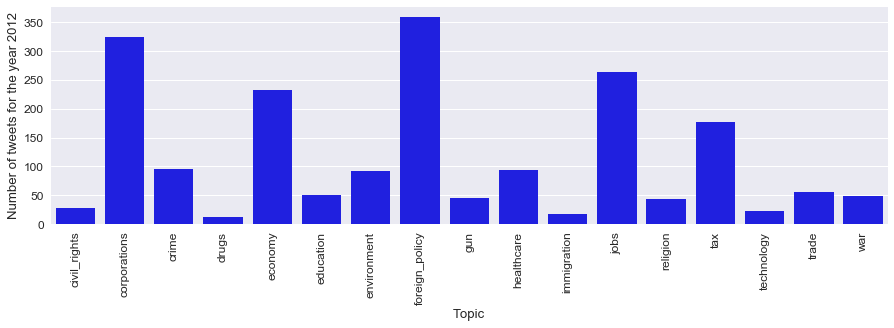

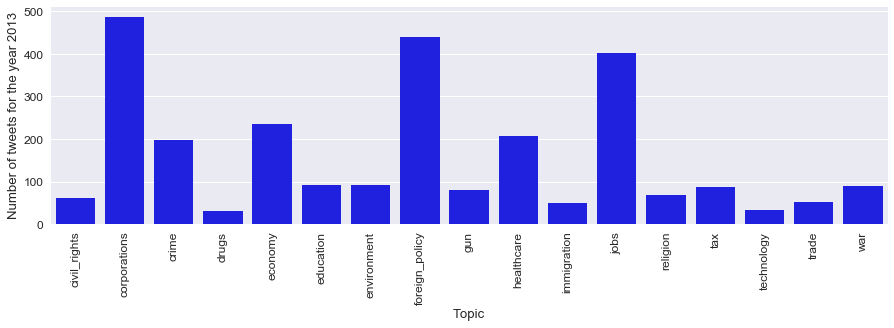

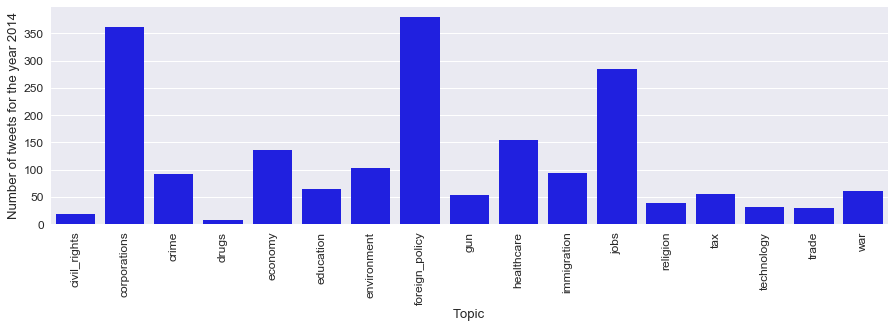

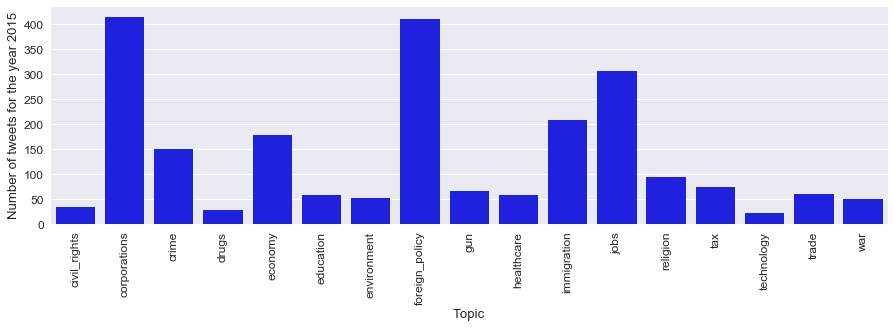

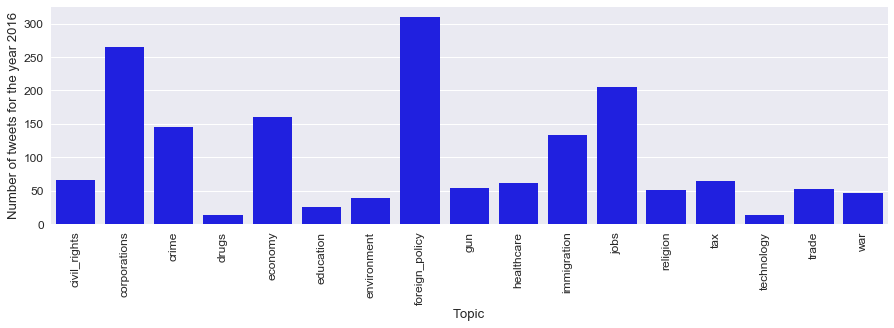

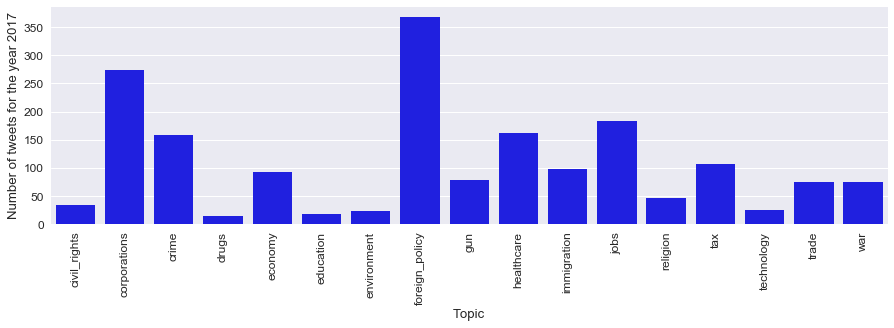

In [45]:
count_by_year = count_by_year_topic.reset_index().set_index('year')
sns.set(font_scale=1.2)
for year in range(2012,2018):
    yearly_data = count_by_year.loc[year].sort_values('topic')
    plt.subplots(figsize=(15,4))
    fig = sns.barplot(data = yearly_data , x='topic', y='Number of tweets', color='blue')
    fig.set(xlabel = 'Topic' , ylabel = 'Number of tweets for the year ' + str (year))
    fig.set_xticklabels(labels = fig.get_xticklabels(), rotation=90)
    plt.savefig('results/trump_topics_' + str(year) + '.png')
    plt.show()

We can see from these plots that the distribution of topics is very similar from one year to another. <br>
The topics of foreign policy, corporations and jobs are systematically more mentioned by Trump than other topics. <br>
For foreign policy and corporations, we can say that these topics might come up more as they are broad topics. However the jobs topic is more specific, and interestingly enough, it is mentioned a lot in Trump's tweets.

## 3. Reactions to Trump's tweets

We now try to see the reactions of people to Trump's tweets, focusing on the different reactions to different topics

#### a. Preliminary analysis using number of favorites and retweets

We start by looking at the average number of retweets and favorites per tweet for each topic mentioned by Trump. We choose to look at the average per tweet and not the sum because the number of tweets per topic differs from one topic to another, therefore, taking the sum would bias the results towards the most mentioned topics.<br>
We use these two fields (favorite_count and retweet_count) as intial metrics to asses the popularity of a topic. However, we will later enrich the analysis by looking at the sentiments of replies from Twitter users to Trump's tweets by topic.

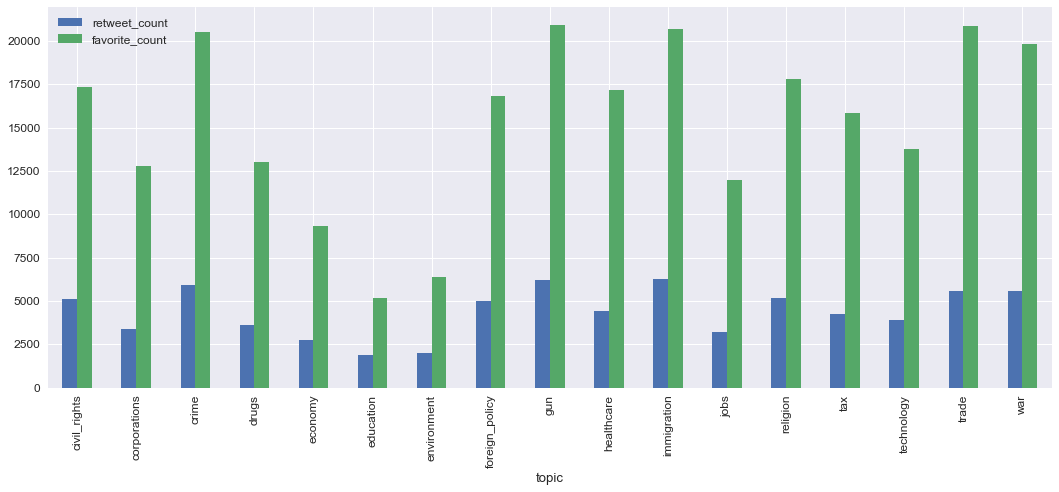

In [46]:
mean_retweet_favorite = trump_topics.groupby('topic').agg({'retweet_count': np.mean, 
                                  'favorite_count': np.mean})
mean_retweet_favorite.head()

mean_retweet_favorite.plot.bar(figsize=(18,7))
plt.savefig('results/fav_retweet.png')

From this plot, we can see that some of the most retweeted topics are also the most favorited topics.
Mainly, the most popular topics when using retweet_count and favorite_count as metrics would be:
1. gun
2. immigration
3. crime
4. trade
5. war

#### b. Analysis using sentiment of replies

We turn out attention to the sentiments of the replies to Trump tweets. We look at how the sentiments of Twitter users change depending on the topic of the tweet. From these sentiments, we asses the popularity of a certain topic addressed by Trump among Twitter users.

First, we look at the number of times topics come up in the replies dataset.

In [47]:
num_tweets_per_topic = replies_topics[['Text', 'Topic']].groupby('Topic').count()
num_tweets_per_topic.columns=['Number of tweets']
num_tweets_per_topic

,Number of tweets
Topic,
civil_rights,2760
corporations,2748
crime,2862
drugs,864
economy,2680
education,2850
environment,2764
foreign_policy,2843
gun,2890


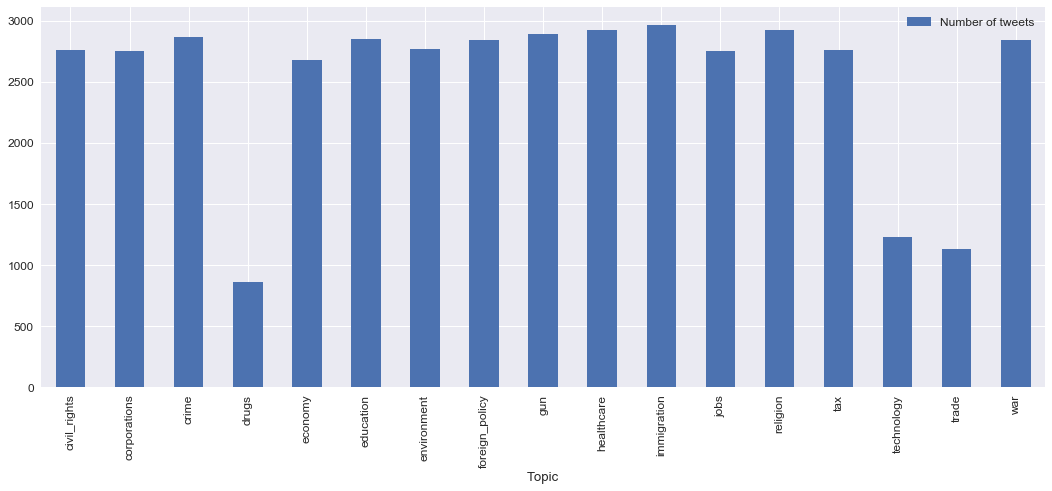

In [48]:
num_tweets_per_topic.plot.bar(figsize=(18,7))
plt.savefig('results/replies_per_topic.png')

Most topics are mentioned in replies equally, except for three topics, which are mentioned almost half as often:
1. drugs
2. technology
3. trade

This means that Twitter users generally don't react much to tweets by Trump relating to drugs, technology, or trade.

As a preliminary step, we look at the total number of replies to Trump with positive sentiment VS the total number of replies to Trump with negative sentiment, to see if people generally have a positive or negative attitude towards Trump's tweets.

In [49]:
positive_count = replies_topics[replies_topics['Sentiment'] == 1].shape[0]
negative_count =replies_topics[replies_topics['Sentiment'] == -1].shape[0]
total = replies_topics.shape[0]
percent_positive = positive_count/total * 100
percent_negative= negative_count/total * 100
print('The number of positive tweets is '+ str(positive_count) + ' which consists of ' + str(percent_positive) + '% of all replies.')
print('The number of negative tweets is '+ str(negative_count) + ' which consists of ' + str(percent_negative) + '% of all replies.')

The number of positive tweets is 13974 which consists of 32.657162888525356% of all replies.
The number of negative tweets is 28816 which consists of 67.34283711147464% of all replies.


Twitter users generally have a negative reaction to Trump's tweets.

For each topic, we look at the number of replies that had a positive sentiment VS the number of replies that had a negative sentiment.

In [50]:
topic_sentiment_count = replies_topics[['Text', 'Sentiment', 'Topic']].groupby(['Topic', 'Sentiment']).count()
topic_sentiment_count.columns=['Number of tweets']

#show part of df
topic_sentiment_count.head(6)

Number of tweets
Topic        Sentiment                  
civil_rights -1                     1929
              1                      831
corporations -1                     1712
              1                     1036
crime        -1                     1967
              1                      895

/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


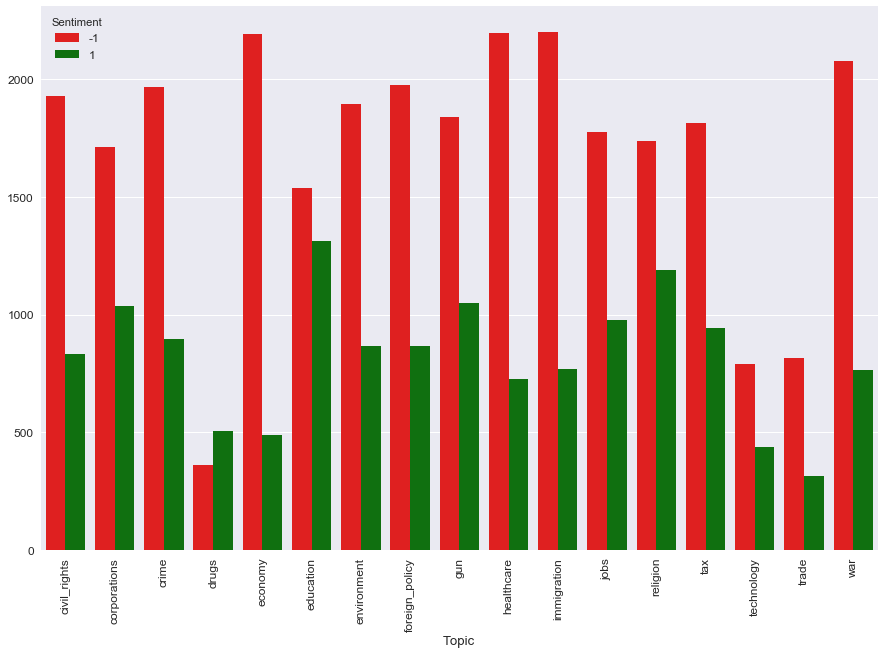

In [51]:
topic_sentiment_count = topic_sentiment_count.reset_index()
plt.subplots(figsize=(15,10))
fig = sns.barplot(data = topic_sentiment_count, x = 'Topic', y='Number of tweets', hue='Sentiment', palette=['red','green'])
fig.set(xlabel = 'Topic' , ylabel = '')
fig.set_xticklabels(labels = fig.get_xticklabels(), rotation=90)
plt.savefig('results/pos_neg_topics.png')
plt.show()

For all topics except drugs, Twitter users have more negative reactions than positive ones to Trump's tweets. <br>
To get better insight, we look at the discrepancy between the number of negative tweets and positive tweets for all topics except drugs, to see to what extent people disagree with Trump on a certain topic.

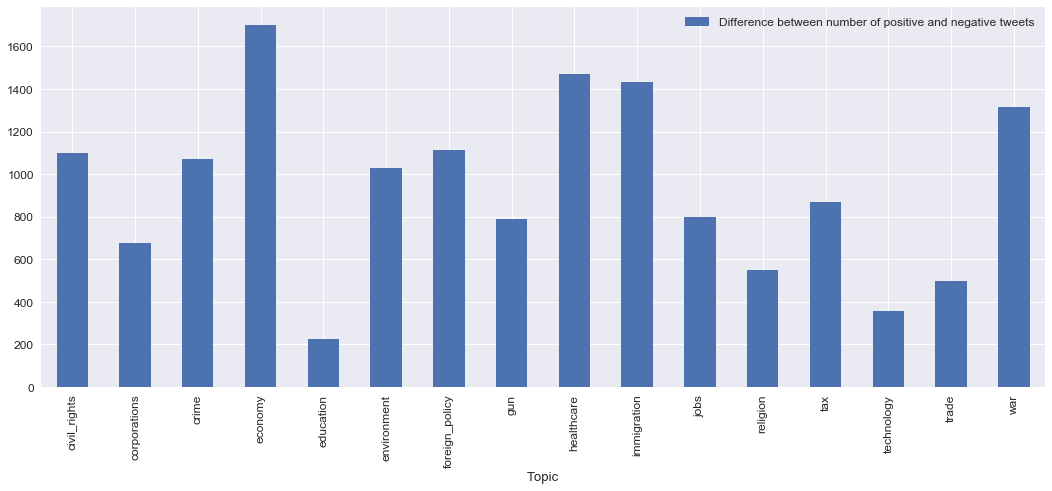

In [52]:
#remove drugs topic
topic_sentiment_count = topic_sentiment_count[topic_sentiment_count['Topic'] != 'drugs']
difference_pos_neg = topic_sentiment_count.groupby('Topic').agg({'Number of tweets': lambda x: max(x) - min(x)})
difference_pos_neg.columns = ['Difference between number of positive and negative tweets']
difference_pos_neg.head()

#plot the differences
difference_pos_neg.plot.bar(figsize = (18, 7))
plt.savefig('results/diff_pos_neg.png')

The top 5 topics on which Twitter users disagree with Trump on are:
1. economy
2. immigration
3. war
4. healthcare
5. foreign policy

Finally, we look at the evolution of the sentiments towards trump over the years, regardless of the topics approaches.<br>

More specifically, we look at the evolution of the percentage of positive replies to Trump.

In [53]:
replies_topics.groupby('year').count()

,Language,Date_Time,User,Text,Text_processed,Sentiment,Topic
year,,,,,,,
2012,12997,12997,12997,12997,12997,12997,12997
2013,9210,9210,9210,9210,9210,9210,9210
2014,2070,2070,2070,2070,2070,2070,2070
2015,15538,15538,15538,15538,15538,15538,15538
2016,2975,2975,2975,2975,2975,2975,2975


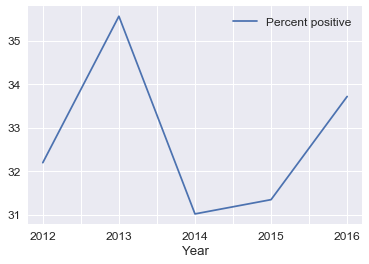

In [54]:
#count number of positive and negative tweets for every year
neg_pos_year = replies_topics[['Text', 'Sentiment', 'year']].groupby(['year', 'Sentiment']).count()
neg_pos_year.columns =['Number of tweets']

neg_pos_year = neg_pos_year.reset_index()


# #split df into two dfs : counts of positive tweets and counts of negative tweets
positive_by_year = neg_pos_year[neg_pos_year['Sentiment'] == 1].drop('Sentiment', axis=1)
positive_by_year.columns = ['Year', 'Positive tweets']
negative_by_year = neg_pos_year[neg_pos_year['Sentiment'] == -1].drop('Sentiment', axis=1)
negative_by_year.columns = ['Year', 'Negative tweets']

#merge the two dataframes
merge_pos_neg = pd.merge(positive_by_year, negative_by_year, on='Year')

#create a column with percentage of positive tweets 
merge_pos_neg['Percent positive'] = merge_pos_neg['Positive tweets'] * 100 /(merge_pos_neg['Positive tweets'] + merge_pos_neg['Negative tweets'])
merge_pos_neg

merge_pos_neg.plot(x='Year', y='Percent positive')
plt.savefig('results/perc_pos_time.png')

The percentage of positive tweets fluctuates within a narrow range (31-38%). It reached its lowest in 2014, one year before the electoral campaign started, and is at its highest in 2013. 